In [1]:
# import modules

from gbdxtools import Interface
from gbdxtools import CatalogImage
from gbdxtools.task import env
from shapely import geometry
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import rasterio
from shapely.geometry import box, shape
import rasterio
import rasterio.features
from rasterio import features
from shapely.ops import cascaded_union
from functools import partial
import pyproj
from shapely.ops import transform

import fiona
import rasterio
import rasterio.mask
import ogr
from matplotlib import pyplot
from shapely.geometry.polygon import LinearRing, Polygon

from shapely.geometry import mapping, Polygon

import osr



# scikit-image modules for image science operators
from skimage import filters, morphology

In [2]:
## useful functions

# convert a list of numbers to a string list without brackets or parentheses 
def listToStringWithoutBrackets(list1):
    return str(list1).replace('[','').replace(']','')

In [3]:
# set area

bbox_large_area_float = [4.795532226562501, 52.36496281504866, 4.888916015625001, 52.41487819320523]

# bbox_large_area_float = [-43.26416015625001, -22.950014703118647, -43.121337890625, -22.873523987658665]

bbox_large_area_str = listToStringWithoutBrackets(bbox_large_area_float)


UTM_EPSG_code = 'EPSG:32631' #'EPSG:32723'# 'EPSG:3095' #



Fetching Image... 153 tiles


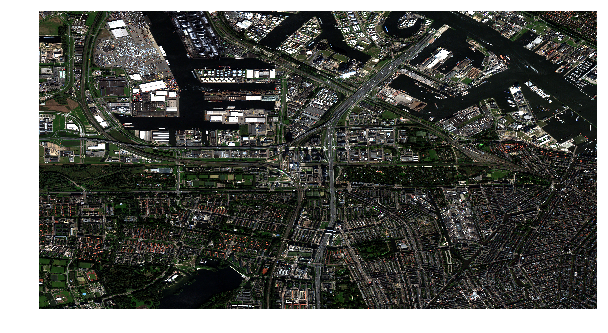

In [4]:
# fetch images

from gbdxtools.task import env
from gbdxtools import CatalogImage
%matplotlib inline

catalog_id = env.inputs.get('catalog_id', '1030050045F94600')#104001003918D000 104001000131A100 
bbox = env.inputs.get('bbox', bbox_large_area_str)

image = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")))
image.plot(w=10, h=10)

In [5]:
# get some metadata

# connect to gbdx
gbdx = Interface()

# Collect the metadata
metadata = image.ipe.metadata['image']
# What are those bands?
print 'Band Names:', metadata['sensorName']


Band Names: 8-band (Coastal, Blue, Green, Yellow, Red, Red-edge, NIR1, NIR2) Multispectral


Fetching Image... 153 tiles


Text(0.5,1,u'Water Index')

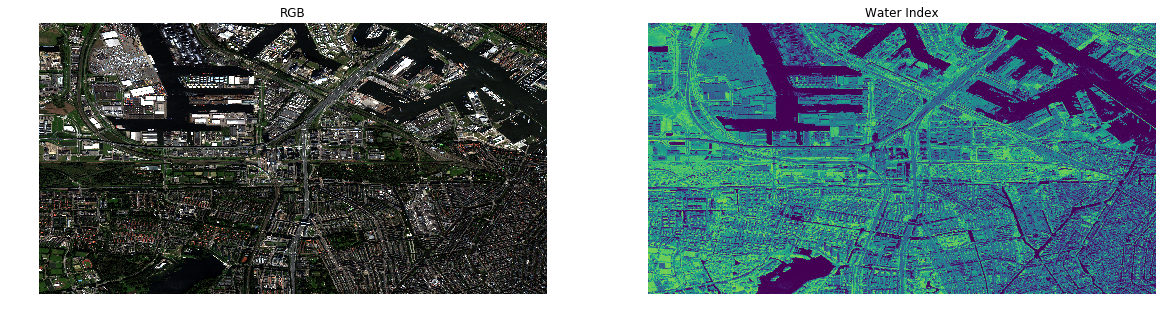

In [6]:
# Calculate the water index
water_index = (image[7,:,:] - image[0,:,:]) / (image[7,:,:] + image[0,:,:])

# Also extract the visible color (i.e., Red-Green-Blue) bands, which we'll use for side-by-side plotting as we proceed
rgb = image.rgb()

# View the results
plt.figure(figsize=(20,15))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(rgb)
plt.title("RGB")

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(water_index, vmin=-1, vmax=1)
plt.title("Water Index")

In [7]:
# calculate water index and ndvi

rgb = image.rgb()
coastal = image[0,:,:].astype(np.float32)
red = image[4,:,:].astype(np.float32)
nir = image[6,:,:].astype(np.float32)
nir2 = image[7,:,:].astype(np.float32)

water_index = (nir2 - coastal)/(nir2 + coastal)

ndvi = np.clip((nir - red)/(nir + red), -1, 1)
A = ndvi >= 0.6
B = ndvi.all() >= 0.3 and ndvi.all() < 0.6
C = ndvi < 0.3
plants= A*2+B*3+C



Fetching Image... 153 tiles


Text(0.5,1,u'Water Mask')

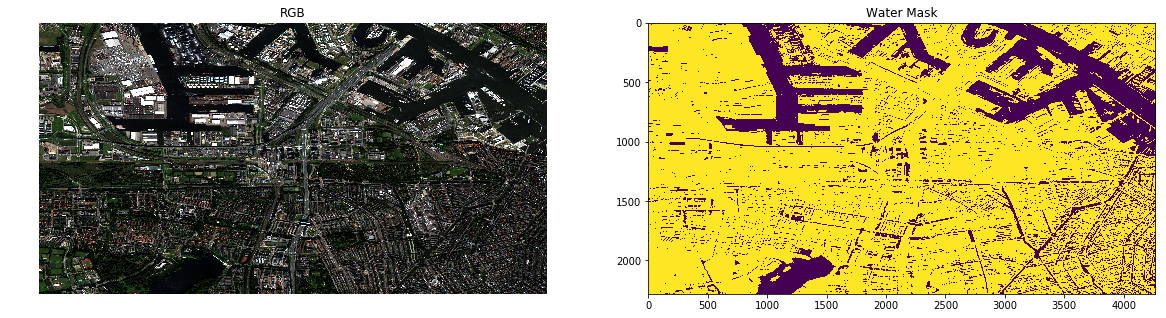

In [8]:
# First, clean up any nan values
water_index[np.isnan(water_index)] = 0

# Next, run a gaussian smoothing kernel over the image. This will smooth out localized noise in the water index
# by use a focal moving window.
water_index_smoothed = filters.gaussian(water_index, preserve_range=True)

# Finally, we are going to run the thresholding. We are going to use a method called Otsu's method,
# which picks the threshold that will maximize the variance between the values on either side of it.
# For more info on Otsu's Method, see: 
# http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_thresholding.html
# and http://en.wikipedia.org/wiki/Otsu’s_method.


# Find the threshold
binary_threshold = -0.65 

# Apply the threshold
binary_water = water_index_smoothed >= binary_threshold

# View the results
plt.figure(figsize=(20,15))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(rgb)
plt.title("RGB")

plt.subplot(1, 2, 2)
plt.axis('on')
plt.imshow(binary_water, vmin=0, vmax=1)
plt.title("Water Mask")

In [9]:
# Specify the minimum feature size in square meters, and then use info from the image metadata 
# to translate to grid cell count.

# Set the minimum feature size to 400 sq km (400,000 m)
min_feature_size_m2 = 40.

# From the image metadata, we can determine the area of a single grid cell
cell_height_m = image.ipe.metadata['image']['groundSampleDistanceMeters']
cell_area_m2 = cell_height_m**2

# Finally, use the cell size to convert the minimum feature size to grid cells
min_feature_size_cells = np.round((min_feature_size_m2/cell_area_m2)).astype('int64')

# What is the minimum feature size in square meters and grid cells?
print min_feature_size_m2, 'sq. m'
print min_feature_size_cells, 'grid cells'

40.0 sq. m
6 grid cells


Text(0.5,1,u'Cleaned Water Mask')

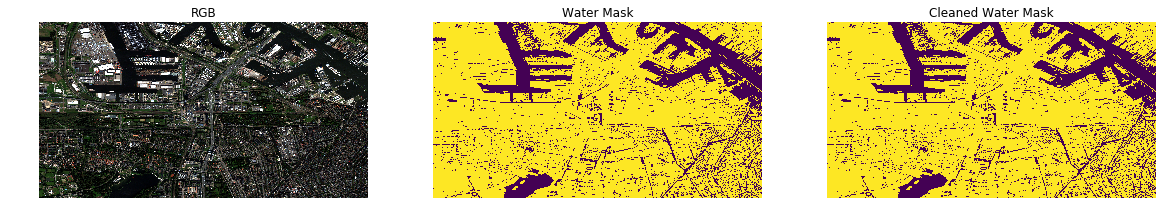

In [10]:
# First, remove the small holes
water_cleaned = morphology.remove_small_holes(binary_water, min_feature_size_cells)

# Then remove the small objects
water_cleaned = morphology.remove_small_objects(water_cleaned, min_feature_size_cells, connectivity=2)

# Combine all layers for easier analysis
all_layers = plants+water_cleaned*3

# View the results
plt.figure(figsize=(20,15))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(rgb)
plt.title("RGB")

plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(binary_water, vmin=0, vmax=1)
plt.title("Water Mask")

plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(water_cleaned, vmin=0, vmax=1)
plt.title("Cleaned Water Mask")

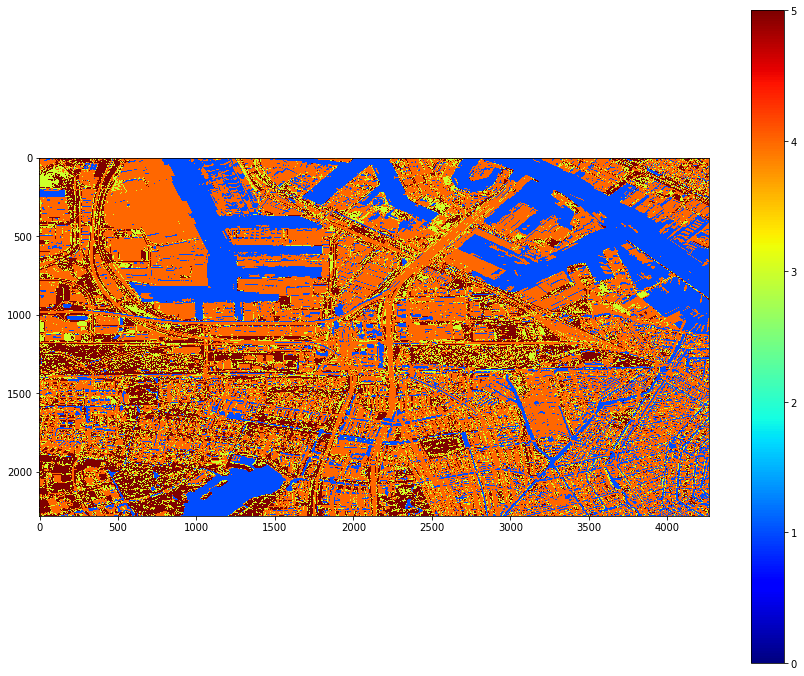

In [11]:
all_layers = plants+water_cleaned*3

import matplotlib.pyplot as plt
%matplotlib inline

def plot(image, w=15, h=12, cmap='jet'):
    f, ax = plt.subplots(1, figsize=(w,h))
    ax.axis('on')
    plt.imshow(image, cmap=cmap)
    plt.colorbar()
    plt.show()

plot(all_layers)